In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../../src')))

from models import (
    advection_diffusion_model,
    partitioned_threshold_model,
    partitioned_threshold_model_nonlinear,
)
from plotting import set_nature_style, plot_maps_area_slope
from utils import find_project_root, resample_from_1m
from analysis import (
    ks_from_loglog_fixed_theta,
    slope_area_arrays_from_elevation,
    ks_obs_from_observed,
    ks_mod_from_modeled,
)

import numpy as np
import copy
import TopoAnalysis.dem as d
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext

In [2]:
"""
UPDATED MAIN LOOP + RESULTS STRUCTURE (adds Ks_obs, ratio, CSV export)
and includes the NEW plots (ratio vs dx + exponent bars), plus the simple Ks_mod vs dx plot.

What this code does per (location, tile, dx):

1) Start from original observed elevation field (your loaded 1 m filled grid)
2) Downsample to target resolution dx (nan-aware)
3) Recompute hydrology at that dx: Filled -> FlowDirectionD8 -> Area
4) Run your chi integrator / solver to reconstruct synthetic (modeled) elevation field
   - Here: uses `advection_diffusion_model(...)` closure, because that is what your pipeline currently expects.
   - If your chi-integrator has a different factory/signature, swap it in at the marked line.
5) Compute Ks_obs from the observed elevation at that dx (using same fd/area, fixed theta)
6) Compute Ks_mod from the synthetic elevation at that dx (same fd/area, fixed theta)
7) Compute ratio = Ks_mod / Ks_obs
8) Save all_results + plot_dict + write CSV
9) Plot:
   A) Ks_mod vs dx (simple)
   B) Ratio vs dx (per-tile faint lines + median±IQR by loc + ratio=1 reference + slope guide)
   C) Per-tile exponent alpha_R in ratio ~ dx^{-alpha_R} (with optional bootstrap CI)
"""

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

import TopoAnalysis.dem as d

# ============================================================
# REQUIRED: bring your solver factory into scope
# ============================================================
# Must provide:
#   advection_diffusion_model(dem_obj, area_obj, fd_obj, theta) -> callable(U,K,D)->Z_model
# If you are actually using a chi-integrator with a different API, swap it in below
# at the line marked:  >>> SOLVER FACTORY <<<


# ============================================================
# USER CONFIG
BASE_ROOT = os.path.abspath("../../data")

# Log-spaced dx targets (unique, sorted)
N_DX = 25
DX_TARGETS = np.logspace(np.log10(5.0), np.log10(100.0), N_DX)  # <-- 1 m to 30 m per your stated procedure
DX_TARGETS = np.unique(DX_TARGETS)
DX_TARGETS = np.sort(DX_TARGETS).tolist()

MIN_AREA = 1E5
VERTICAL_INTERVAL = 10
RESAMPLE_ORDER = 1  # 1=bilinear, 3=bicubic

# Output CSV path
OUT_CSV = os.path.join(BASE_ROOT, "ks_resolution_ratio_results-1E5-AREA-coarser.csv")

# Plot style (keep your current)
set_nature_style()

# ============================================================
# INPUT PARAMETERS
U_BY_LOC = {"GM": 1.47e-4, "AP": 5.5e-5}

KD_GM = {
    1: (2.2e-05, 1.0e-02),
    2: (6.1e-05, 1.0e-02),
    3: (1.9e-05, 2.1e-02),
    4: (3.5e-05, 9.8e-03),
    5: (5.9e-05, 9.0e-03),
}
KD_AP = {
    1: (4.0e-07, 2.8e-03),
    2: (2.9e-07, 2.8e-03),
    3: (4.9e-07, 2.7e-03),
    4: (2.0e-06, 2.5e-03),
    5: (3.6e-06, 2.5e-03),
}

THETA_GM = {1: 0.379, 2: 0.308, 3: 0.417, 4: 0.313, 5: 0.300}
THETA_AP = {1: 0.562, 2: 0.592, 3: 0.542, 4: 0.438, 5: 0.400}

# ============================================================
def tile_dir(location, tile_idx):
    return os.path.join(BASE_ROOT, location, f"tile{tile_idx}")

def root_1m_filled(location, tile_idx):
    base = tile_dir(location, tile_idx)
    p = os.path.join(base, f"{location}_1m_best_tile_filled")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing 1m filled root: {p}")
    return p

# ============================================================
# Core per-(tile,dx) run (adds Ks_obs and ratio)
def run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, D, theta):
    # 1) Start from observed 1 m elevation, downsample to dx
    if np.isclose(dx_target, 1.0):
        dem_dx = dem_1m_filled
    else:
        dem_dx = resample_from_1m(dem_1m_filled, dx_target=float(dx_target), order=RESAMPLE_ORDER)

    # 2) Hydrology at this resolution
    filled_obs = d.FilledElevation(elevation=dem_dx)
    fd = d.FlowDirectionD8(flooded_dem=filled_obs)
    area = d.Area(flow_direction=fd)

    # 3) Observed Ks at this resolution (reference)
    Ks_obs, r2_obs, n_obs, Amax_obs = ks_obs_from_observed(filled_obs, area, fd, theta)

    # 4) Reconstruct synthetic elevation with your solver
    # >>> SOLVER FACTORY <<<  (swap this line if your chi-integrator differs)
    solver = advection_diffusion_model(dem_dx, area, fd, theta)  # must be in scope

    # If you have a chi integrator and it does NOT take (U,K,D), replace accordingly.
    Z_model = solver(U, K, D)

    # 5) Modeled Ks from synthetic elevation
    Ks_mod, r2_mod, n_mod, Amax_mod = ks_mod_from_modeled(Z_model, dem_dx, area, fd, theta)

    # 6) Ratio
    ratio = np.nan
    if np.isfinite(Ks_mod) and np.isfinite(Ks_obs) and Ks_mod > 0 and Ks_obs > 0:
        ratio = float(Ks_mod / Ks_obs)

    return {
        "location": str(location),
        "tile": int(tile_idx),
        "dx": float(dx_target),
        "U": float(U),
        "K": float(K),
        "D": float(D),
        "theta": float(theta),

        "Ks_obs": float(Ks_obs),
        "r2_obs": float(r2_obs),
        "npts_obs": int(n_obs),
        "Amax_obs": float(Amax_obs),

        "Ks_mod": float(Ks_mod),
        "r2_mod": float(r2_mod),
        "npts_mod": int(n_mod),
        "Amax_mod": float(Amax_mod),

        "ratio_mod_over_obs": float(ratio),
    }

# ============================================================
# MAIN LOOP (writes all_results + plot_dict + CSV)
DX_TARGETS = np.unique(np.array(DX_TARGETS, dtype=float))
DX_TARGETS = np.sort(DX_TARGETS).tolist()

all_results = []
all_errors = []

for location in ["GM", "AP"]:
    U = U_BY_LOC[location]
    KD = KD_GM if location == "GM" else KD_AP
    TH = THETA_GM if location == "GM" else THETA_AP

    for tile_idx in [1, 2, 3, 4, 5]:
        try:
            p = root_1m_filled(location, tile_idx)
            dem_1m_filled = d.FilledElevation.load(p)
        except Exception as e:
            all_errors.append((location, tile_idx, "LOAD_1M", str(e)))
            print(f"[FAIL] {location} Tile {tile_idx}: load 1m filled failed: {e}")
            continue

        K, Dcoef = KD[tile_idx]
        theta = TH[tile_idx]

        for dx_target in DX_TARGETS:
            try:
                r = run_at_target_dx(location, tile_idx, dem_1m_filled, dx_target, U, K, Dcoef, theta)
                all_results.append(r)
                print(
                    f"[OK] {location} T{tile_idx} dx={dx_target:6.2f} | "
                    f"Ks_mod={r['Ks_mod']:.3e} | Ks_obs={r['Ks_obs']:.3e} | "
                    f"ratio={r['ratio_mod_over_obs']:.3f} | "
                    f"n_mod={r['npts_mod']} n_obs={r['npts_obs']}"
                )
            except Exception as e:
                all_errors.append((location, tile_idx, dx_target, str(e)))
                print(f"[FAIL] {location} T{tile_idx} dx={dx_target}: {e}")

if len(all_results) == 0:
    raise RuntimeError("No successful runs. Inspect all_errors.")

# -------------------------
# Build plot_dict
# -------------------------
def build_plot_dict(all_results):
    out = {}
    grouped = {}
    for r in all_results:
        key = (r["location"], int(r["tile"]))
        grouped.setdefault(key, []).append(r)

    for key, rows in grouped.items():
        rows = sorted(rows, key=lambda rr: float(rr["dx"]))
        out[key] = {
            "rows": rows,
            "dx": np.array([rr["dx"] for rr in rows], dtype=float),
            "Ks_mod": np.array([rr["Ks_mod"] for rr in rows], dtype=float),
            "Ks_obs": np.array([rr["Ks_obs"] for rr in rows], dtype=float),
            "ratio": np.array([rr["ratio_mod_over_obs"] for rr in rows], dtype=float),
            "r2_mod": np.array([rr["r2_mod"] for rr in rows], dtype=float),
            "r2_obs": np.array([rr["r2_obs"] for rr in rows], dtype=float),
            "npts_mod": np.array([rr["npts_mod"] for rr in rows], dtype=float),
            "npts_obs": np.array([rr["npts_obs"] for rr in rows], dtype=float),
            "theta": float(rows[0]["theta"]),
            "K": float(rows[0]["K"]),
            "D": float(rows[0]["D"]),
            "U": float(rows[0]["U"]),
        }
    return out

plot_dict = build_plot_dict(all_results)

# -------------------------
# Write CSV (so you can upload it here)
# -------------------------
# fieldnames = [
#     "location", "tile", "dx", "theta", "U", "K", "D",
#     "Ks_obs", "r2_obs", "npts_obs", "Amax_obs",
#     "Ks_mod", "r2_mod", "npts_mod", "Amax_mod",
#     "ratio_mod_over_obs"
# ]

# with open(OUT_CSV, "w", newline="") as f:
#     w = csv.DictWriter(f, fieldnames=fieldnames)
#     w.writeheader()
#     for r in sorted(all_results, key=lambda rr: (rr["location"], rr["tile"], rr["dx"])):
#         w.writerow({k: r.get(k, np.nan) for k in fieldnames})

# print(f"\n[INFO] Wrote CSV: {OUT_CSV}")

# -------------------------
# Helpers for ratio plot + stats
# -------------------------
def by_tile_from_all_results(all_results):
    out = {}
    for r in all_results:
        key = (r["location"], int(r["tile"]))
        out.setdefault(key, []).append(r)
    for k in out:
        out[k] = sorted(out[k], key=lambda rr: float(rr["dx"]))
    return out

def get_series(series):
    dx = np.array([rr["dx"] for rr in series], dtype=float)
    R  = np.array([rr["ratio_mod_over_obs"] for rr in series], dtype=float)
    return dx, R

def group_stats_ratio(tile_data, loc, dx_grid):
    vals_by_dx = {float(d): [] for d in dx_grid}
    for (L, _t), series in tile_data.items():
        if L != loc:
            continue
        dx, R = get_series(series)
        for d in dx_grid:
            j = np.where(np.isclose(dx, float(d), rtol=0.0, atol=1e-10))[0]
            if j.size != 1:
                continue
            i = j[0]
            if np.isfinite(R[i]) and R[i] > 0:
                vals_by_dx[float(d)].append(R[i])

    med, q25, q75 = [], [], []
    for d in dx_grid:
        arr = np.array(vals_by_dx[float(d)], dtype=float)
        if arr.size == 0:
            med.append(np.nan); q25.append(np.nan); q75.append(np.nan)
        else:
            med.append(np.nanmedian(arr))
            q25.append(np.nanpercentile(arr, 25))
            q75.append(np.nanpercentile(arr, 75))
    return np.array(med), np.array(q25), np.array(q75)

[OK] GM T1 dx=  5.00 | Ks_mod=5.958e+01 | Ks_obs=5.010e+00 | ratio=11.891 | n_mod=270 n_obs=270
[OK] GM T1 dx=  5.66 | Ks_mod=5.501e+01 | Ks_obs=5.000e+00 | ratio=11.001 | n_mod=240 n_obs=240
[OK] GM T1 dx=  6.42 | Ks_mod=5.091e+01 | Ks_obs=4.994e+00 | ratio=10.193 | n_mod=209 n_obs=209
[OK] GM T1 dx=  7.27 | Ks_mod=4.621e+01 | Ks_obs=5.066e+00 | ratio=9.122 | n_mod=186 n_obs=186
[OK] GM T1 dx=  8.24 | Ks_mod=4.124e+01 | Ks_obs=5.016e+00 | ratio=8.221 | n_mod=159 n_obs=159
[OK] GM T1 dx=  9.33 | Ks_mod=3.684e+01 | Ks_obs=4.887e+00 | ratio=7.538 | n_mod=140 n_obs=140
[OK] GM T1 dx= 10.57 | Ks_mod=3.271e+01 | Ks_obs=5.070e+00 | ratio=6.452 | n_mod=124 n_obs=124
[OK] GM T1 dx= 11.98 | Ks_mod=2.942e+01 | Ks_obs=5.132e+00 | ratio=5.733 | n_mod=104 n_obs=104
[OK] GM T1 dx= 13.57 | Ks_mod=2.602e+01 | Ks_obs=5.028e+00 | ratio=5.175 | n_mod=95 n_obs=95
[OK] GM T1 dx= 15.38 | Ks_mod=2.305e+01 | Ks_obs=5.087e+00 | ratio=4.531 | n_mod=79 n_obs=79
[OK] GM T1 dx= 17.42 | Ks_mod=2.088e+01 | Ks_obs=5.

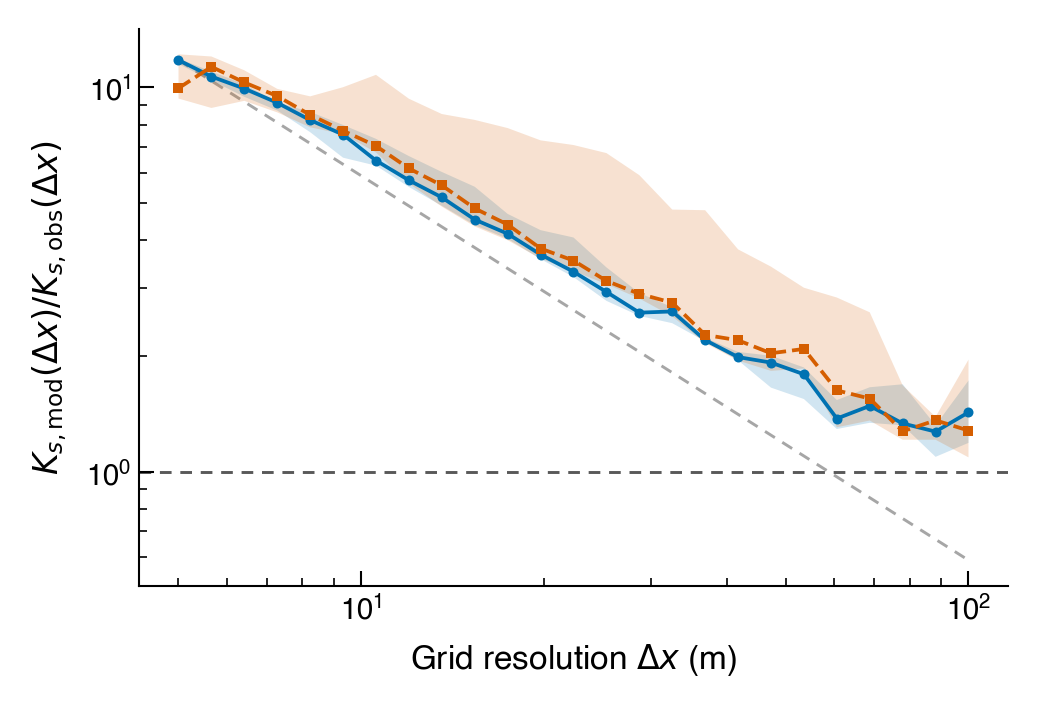

In [3]:
# -------------------------
# Plot 1: ratio (MEDIAN + IQR ONLY; GM vs AP)
# -------------------------
tile_data = by_tile_from_all_results(all_results)
dx_all = np.array(sorted({float(r["dx"]) for r in all_results}), dtype=float)

# Color-blind friendly, high-contrast pair (Okabe–Ito palette)
# (Good in print, and still distinct when desaturated)
COL_GM = "#0072B2"  # blue
COL_AP = "#D55E00"  # vermillion

fig1, ax1 = plt.subplots(figsize=(3.5, 2.4))

def plot_median_iqr(ax, x, med, q25, q75, color, marker, linestyle):
    x = np.asarray(x, float)
    med = np.asarray(med, float)
    q25 = np.asarray(q25, float)
    q75 = np.asarray(q75, float)

    m = np.isfinite(x) & np.isfinite(med) & np.isfinite(q25) & np.isfinite(q75) & (med > 0) & (q25 > 0) & (q75 > 0)
    if np.sum(m) < 2:
        return

    # IQR band: no edges, clearly a band (not lines)
    ax.fill_between(
        x[m], q25[m], q75[m],
        facecolor=color,
        alpha=0.18,
        linewidth=0,
        edgecolor="none",
        interpolate=True,
        zorder=1,
    )

    # Median: thin line + small markers
    ax.plot(
        x[m], med[m],
        linestyle + marker,
        color=color,
        lw=0.9,
        ms=2.4,
        mfc=color,
        mec=color,
        mew=0.0,
        zorder=3,
    )

# Compute and plot GM and AP summaries
med_gm, q25_gm, q75_gm = group_stats_ratio(tile_data, "GM", dx_all)
med_ap, q25_ap, q75_ap = group_stats_ratio(tile_data, "AP", dx_all)

plot_median_iqr(ax1, dx_all, med_gm, q25_gm, q75_gm, COL_GM, marker="o", linestyle="-")
plot_median_iqr(ax1, dx_all, med_ap, q25_ap, q75_ap, COL_AP, marker="s", linestyle="--")

# Reference: model = observed
ax1.axhline(1.0, lw=0.7, color="0.35", ls="--", dashes=(4, 3), zorder=0)

# -1 slope guide (anchor to GM median at finest valid dx; else AP)
def _first_valid(x, y):
    j = np.where(np.isfinite(x) & np.isfinite(y) & (y > 0))[0]
    return j[0] if j.size else None

j0 = _first_valid(dx_all, med_gm)
anchor_series = med_gm
if j0 is None:
    j0 = _first_valid(dx_all, med_ap)
    anchor_series = med_ap

if j0 is not None:
    dx0 = dx_all[j0]
    y0 = anchor_series[j0]
    dx_line = np.array([np.nanmin(dx_all), np.nanmax(dx_all)], dtype=float)
    guide = y0 * (dx_line / dx0) ** (-1.0)
    ax1.plot(dx_line, guide, "--", lw=0.7, color="0.65", dashes=(4, 3), zorder=0)

# Axes / formatting (Nature-ish)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"Grid resolution $\Delta x$ (m)")
ax1.set_ylabel(r"$K_{s,\mathrm{mod}}(\Delta x)/K_{s,\mathrm{obs}}(\Delta x)$")

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
ax1.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax1.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax1.tick_params(which="both", pad=2)

fig1.tight_layout()

# Vector export for Illustrator:
# fig1.savefig("ratio_vs_dx_median_IQR_GM_AP.pdf", format="pdf", bbox_inches="tight", pad_inches=0.02)

plt.show()